<h2 style='color:blue' align='center'>Bollywood Celebrity Image Classification<h2>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive

/content/drive


In [4]:
cd MyDrive/Colab\ Notebooks/model

[Errno 2] No such file or directory: 'MyDrive/Colab Notebooks/model'
/content/drive/MyDrive/Colab Notebooks/model


In [5]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

<h3 style='color:purple'>(1) Preprocessing: Detect face and eyes</h3>

#### When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.</h4>

#### Now how do you detect face and eyes?

We will use haar cascade from opencv for this. Here is an article on this: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html?highlight=haar

In [54]:
img = cv2.imread('./test_images/Deepika Padukone.jpg')
img.shape

(586, 474, 3)

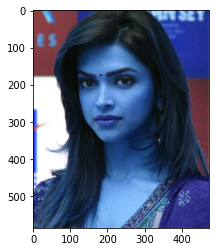

In [55]:
plt.imshow(img)

In [56]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(586, 474)

In [57]:
gray

array([[100,  99,  84, ...,  80,  84,  84],
       [ 99,  98,  84, ...,  79,  83,  83],
       [ 97,  97,  82, ...,  78,  82,  82],
       ...,
       [ 84,  92,  97, ...,  65,  64,  64],
       [114,  91,  87, ...,  63,  58,  86],
       [114,  91,  87, ...,  63,  58,  86]], dtype=uint8)

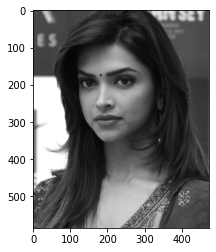

In [58]:
plt.imshow(gray, cmap='gray')

In [59]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 84, 104, 242, 242]], dtype=int32)

In [60]:
(x,y,w,h) = faces[0]
x,y,w,h

(84, 104, 242, 242)

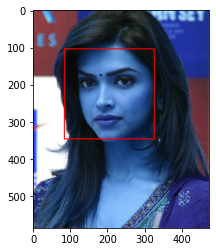

In [61]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

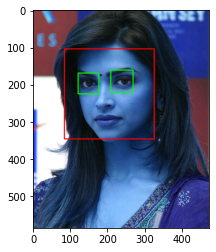

In [62]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

<h3 style='color:purple'>(2) Preprocessing: Crop the facial region of the image</h3>

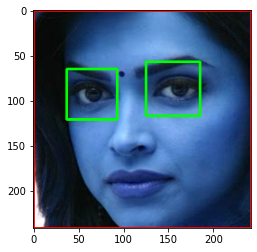

In [63]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [64]:
cropped_img = np.array(roi_color)
cropped_img.shape

(242, 242, 3)

<h3 style='color:purple'>(3) Preprocessing: Use wavelet transform as a feature for traning our model</h3>

#### In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc

### Wavelet transform

In [65]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

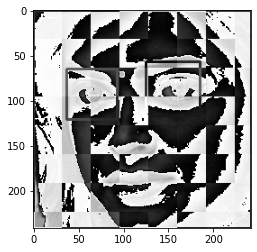

In [66]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

#### You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

<h3 style='color:purple'>(3) Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region</h3>

####  Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [67]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

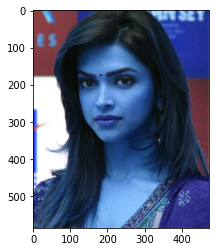

In [68]:
original_image = cv2.imread('./test_images/Deepika Padukone.jpg')
plt.imshow(original_image)

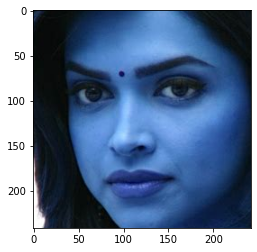

In [70]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/Deepika Padukone.jpg')
try:
    cropped_image.shape
    plt.imshow(cropped_image)
except:
    print('0')

**In below image face is not very clear and it doesn't have two eyes clearly visible**

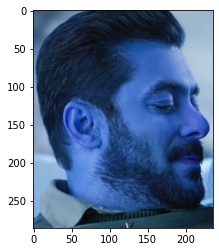

In [74]:
org_image_obstructed = cv2.imread('./test_images/salman khan.jpg')
plt.imshow(org_image_obstructed)

In [76]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/salman khan.jpg')
try:
    cropped_image.shape
    plt.imshow(cropped_image)
except:
    print('0')

0


**Above cropped_image_no_2_eyes is None which means we should ignore this image and we will not use such image for model training**

In [73]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [25]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [26]:
img_dirs

['./dataset/Shahrukh Khan',
 './dataset/Salman khan',
 './dataset/Alia Bhatt',
 './dataset/Deepika Padukone']

**Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code**

In [27]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [28]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1 

Generating cropped images in folder:  ./dataset/cropped/Shahrukh Khan
Generating cropped images in folder:  ./dataset/cropped/Salman khan
Generating cropped images in folder:  ./dataset/cropped/Alia Bhatt
Generating cropped images in folder:  ./dataset/cropped/Deepika Padukone


### Now you should have cropped folder under datasets folder that contains cropped images

### Manually examine cropped folder and delete any unwanted images

In [29]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'Alia Bhatt': ['./dataset/cropped/Alia Bhatt/Alia Bhatt1.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt2.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt3.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt4.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt5.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt6.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt7.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt8.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt9.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt10.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt11.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt12.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt13.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt14.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt15.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt16.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt17.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt18.png',
  './dataset/cropped/Alia Bhatt/Alia Bhatt19.png',
  './dataset/cropped/Alia 

In [30]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Alia Bhatt': 2, 'Deepika Padukone': 3, 'Salman khan': 1, 'Shahrukh Khan': 0}

### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [31]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [32]:
len(X[0])

4096

In [33]:
32*32*3 + 32*32

4096

In [34]:
X[0]

array([[ 67],
       [ 71],
       [ 59],
       ...,
       [133],
       [254],
       [ 45]], dtype=uint8)

In [35]:
y[0]

0

In [36]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(1368, 4096)

### Data cleaning process is done. Now we are ready to train our model

We will use SVM with rbf kernel tuned  with heuristic finetuning

In [37]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8976608187134503

In [39]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85        69
           1       0.87      0.89      0.88        98
           2       0.96      0.94      0.95        81
           3       0.91      0.90      0.91        94

    accuracy                           0.90       342
   macro avg       0.90      0.90      0.90       342
weighted avg       0.90      0.90      0.90       342



### Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [40]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [41]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [42]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.870358,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.678376,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.874251,{'logisticregression__C': 1}


In [43]:
best_estimators

{'logistic_regression': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('logisticregression',
                  LogisticRegression(C=1, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=None,
                                     solver='liblinear', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False), 'random_forest': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('randomforestclassifier',
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
            

In [44]:
best_estimators['svm'].score(X_test,y_test)

0.868421052631579

In [45]:
best_estimators['random_forest'].score(X_test,y_test)

0.7631578947368421

In [46]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8654970760233918

In [47]:
best_clf = best_estimators['svm']

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[55,  9,  2,  3],
       [ 5, 90,  2,  1],
       [ 1,  0, 73,  7],
       [ 5,  5,  5, 79]])

Text(69.0, 0.5, 'Truth')

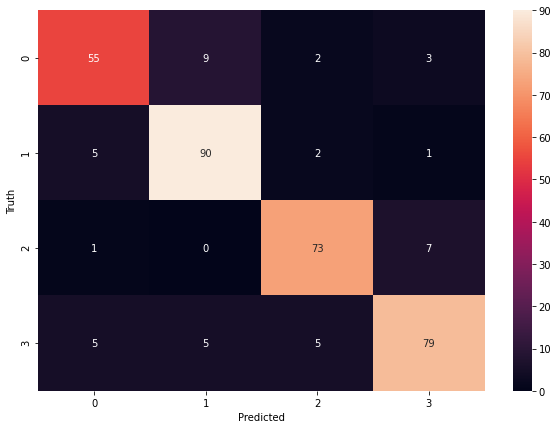

In [49]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [50]:
class_dict

{'Alia Bhatt': 2, 'Deepika Padukone': 3, 'Salman khan': 1, 'Shahrukh Khan': 0}

### Save the trained model

In [51]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

### Save class dictionary

In [52]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))